In [1]:
import Pkg; Pkg.activate("../.."); Pkg.instantiate()
using Revise

  Activating project at `~/Git/KLLS.jl`
Precompiling project...
   6306.2 ms  ✓ KLLS
  1 dependency successfully precompiled in 9 seconds. 273 already precompiled.


In [1]:
using KLLS, LinearAlgebra, Random, DataFrames, NPZ, UnPack, Plots, JSOSolvers

In [2]:
data = npzread("../../data/synthetic-UEG_testproblem.npz")
    
@unpack A, b_avg, b_std, mu = data
b = b_avg
q = convert(Vector{Float64}, mu)
q .= max.(q, 1e-13)
q .= q./sum(q)
C = inv.(b_std) |> diagm
λ = 1e-4
n = length(q)

500

In [9]:
kl = KLLSModel(A, b, C=C, c=zeros(n), q=q, λ=λ)

KL regularized least-squares
   m =        201  bNrm = 3.8e+00
   n =        500  λ    = 1.0e-04
                   τ    = 1.0e+00


In [12]:
# find actual scale
ssSoln = KLLS.solve!(SSModel(kl), SequentialSolve())

Results of univariate zero finding:

* Converged to: 0.9723707164464812
* Algorithm: Roots.Secant()
* iterations: 5
* function evaluations ≈ 9
* stopped as |f(x_n)| ≤ max(δ, |x|⋅ϵ) using δ = atol, ϵ = rtol

Trace:
x₁ = 1.000006055491121,	 fx₁ = -11.168296426207499
x₂ = 1,	 fx₂ = -11.165473817071256
x₃ = 0.9993944508879018,	 fx₃ = -10.884151056261734
x₄ = 0.97596624341156257,	 fx₄ = -1.3180033101595441
x₅ = 0.97273835525590435,	 fx₅ = -0.13420196273474205
x₆ = 0.97237242483445319,	 fx₆ = -0.00062362572470608946
x₇ = 0.97237071644648121,	 fx₇ = -1.8905995868845338e-07




Products with A and A':      1536
Time elapsed (sec)    :       0.0
||Ax-b||₂             :   5.3e-05
Optimality            :   1.5e-08


In [13]:
σ=-ssSoln.dual_obj

-0.010727529904628996

In [53]:
ts = 0.5:0.05:1.4

0.5:0.05:1.4

In [54]:
vts = Float64[] 
for t in ts
    scale!(kl, t)
    tSoln = KLLS.solve!(kl)
    push!(vts, -tSoln.dual_obj)
end

In [ ]:
kl = KLLSModel(A, b, C=C, c=zeros(n), q=q, λ=λ)

KL regularized least-squares
   m =        201  bNrm = 3.8e+00
   n =        500  λ    = 1.0e-04
                   τ    = 1.0e+00


In [ ]:
α=1.9
it = 0
tracer = DataFrame(iter=Int[], l=Float64[], u=Float64[], u_over_l=Float64[], s=Float64[])
l, u, s = 0.0, 0.0, 0.0
solver = JSOSolvers.TrunkSolver(kl)
start_time = time()
t0=0.6
scale!(kl, t0)
t=t0
frames = 5

5

Any[]

In [ ]:
it += 1
l, u, s = KLLS.oracle!(kl, α, σ, solver, tracer) # TODO: weird max time
plot(ts, vts, label="v(t)", xlabel="t", ylabel="v(t)", title="v(t) at iteration $it", ylim=(-2, 40), size=(900, 400))

scatter!([t], [l], label="Lower bound", color=:green, marker=:circle, markersize=3)
scatter!([t], [u], label="Upper bound", color=:blue, marker=:circle, markersize=3)
tk = t - l / s
line_y = [s * (t - kl.scale) + l for t in ts]


# Horizontal line at y = σ
hline!([σ], label="", color=:red, linestyle=:solid)

# Line with slope s
line_y = [s * (t - kl.scale) + l for t in ts]
plot!(ts, line_y, label="Lower minorant", linestyle=:dash)

# Add scatter points
push!(accepted_ts, tk)
push!(σs, σ)
t=tk;
scale!(kl, t)
scatter!(accepted_ts, σs, label="Selected Scales", color=:red, marker=:circle, markersize=3, legend=:outerright)


┌ Info: Saved animation to /Users/mertkipcak/Git/KLLS.jl/experiments/julia/anim_fps1.gif
└ @ Plots /Users/mertkipcak/.julia/packages/Plots/kLeqV/src/animation.jl:156


Plots.AnimatedGif("/Users/mertkipcak/Git/KLLS.jl/experiments/julia/anim_fps1.gif")
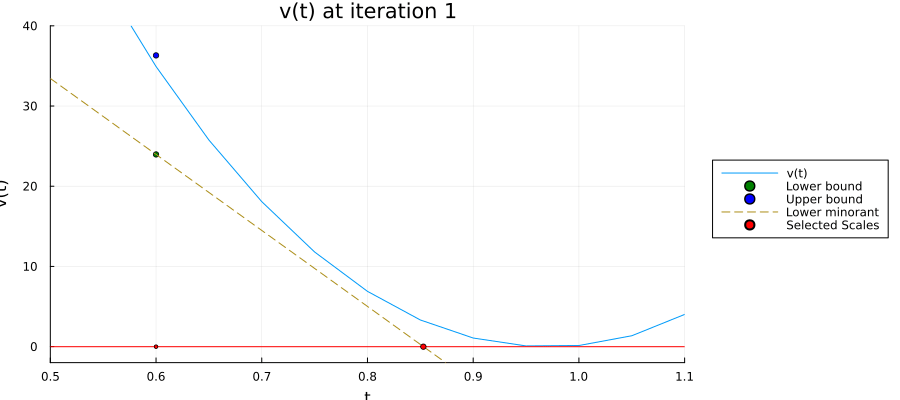

In [118]:
kl = KLLSModel(A, b, C=C, c=zeros(n), q=q, λ=λ)

α=1.7
it = 0
tracer = DataFrame(iter=Int[], l=Float64[], u=Float64[], u_over_l=Float64[], s=Float64[])
l, u, s = 0.0, 0.0, 0.0
solver = JSOSolvers.TrunkSolver(kl)
start_time = time()
t0=0.6
scale!(kl, t0)
t=t0
frames = 5
accepted_ts = [t0]
ls = []
us = []
σs = [σ]

anim = @animate for i in 1:frames
    global it, l, u, s, t, tracer, accepted_ts, σs, kl, α, σ, solver, ts, vts 

    it += 1
    l, u, s = KLLS.oracle!(kl, α, σ, solver, tracer)  # TODO: weird max time
    plot(ts, vts, label="v(t)", xlabel="t", ylabel="v(t)", title="v(t) at iteration $it", xlim=(0.5, 1.1), ylim=(-2, 40), size=(900, 400))

    # Scatter points for bounds
    scatter!([t], [l], label="Lower bound", color=:green, marker=:circle, markersize=3)
    scatter!([t], [u], label="Upper bound", color=:blue, marker=:circle, markersize=3)

    # Calculate tk and plot minorant line
    tk = t - l / s
    line_y = [s * (t - kl.scale) + l for t in ts]

    # Horizontal line at y = σ
    hline!([σ], label="", color=:red, linestyle=:solid)

    # Plot line with slope s
    plot!(ts, line_y, label="Lower minorant", linestyle=:dash)

    # Add scatter points for selected scales
    push!(accepted_ts, tk)
    push!(σs, σ)

    # Update t and rescale
    t = tk
    scale!(kl, t)

    scatter!(accepted_ts[1:end], σs[1:end], label="Selected Scales", color=:red, marker=:circle, markersize=2, legend=:outerright)
    scatter!([accepted_ts[end]], [σs[end]], label="", color=:red, marker=:circle, markersize=3, legend=:outerright)
end
gif(anim, "anim_fps1.gif", fps = 1)


In [100]:
it

0